# OBJECTIFS #

On veut pouvoir prédire la consommation en énergie et l'émission de gaz à effets de serre (GES) à partir des 
données constructeurs des bâtiments dans le cadre de bâtiments ne servant pas à l'habitation. 
On veut également savoir si l'EnergyStarScore est pertinent pour cette prédiction puisqu'il est coûteux à mettre en place.

# Importations #
## Les librairies utiles ##

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from cycler import cycler
import seaborn as sns
import folium
import io
from PIL import Image

## Les jeux de données ##

Sous forme de DataFrame de Pandas

In [2]:
data2015_df = pd.read_csv('Ressources' + '/' + '2015-building-energy-benchmarking.csv')
data2016_df = pd.read_csv('Ressources' + '/' + '2016-building-energy-benchmarking.csv')

Queques informations sur un des jeu de données en exemple.

In [3]:
data2015_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   OSEBuildingID                                                  3340 non-null   int64  
 1   DataYear                                                       3340 non-null   int64  
 2   BuildingType                                                   3340 non-null   object 
 3   PrimaryPropertyType                                            3340 non-null   object 
 4   PropertyName                                                   3340 non-null   object 
 5   TaxParcelIdentificationNumber                                  3338 non-null   object 
 6   Location                                                       3340 non-null   object 
 7   CouncilDistrictCode                                         

# Nettoyage des jeux de doonées corespondant aux attendus du projet #

Suppression des bâtiments destinés à l'habitation

In [4]:
delete2015List = []
delete2016List = []
print('Nombre de bâtiments total respectivement pour les jeux de données 2015 et 2016: {} et {}\n'.format(len(data2015_df), len(data2016_df)))

for i in range(len(data2015_df)):
    if data2015_df.loc[i,'BuildingType'] in ['Multifamily LR (1-4)', 'Multifamily MR (5-9)', 'Multifamily HR (10+)']:
        delete2015List.append(i)
    elif data2015_df.loc[i,'LargestPropertyUseType'] in ['Residence Hall/Dormitory','Multifamily Housing','Other - Lodging/Residential']:
        delete2015List.append(i)

for i in range(len(data2016_df)):
    if data2016_df.loc[i,'BuildingType'] in ['Multifamily LR (1-4)', 'Multifamily MR (5-9)', 'Multifamily HR (10+)']:
        delete2016List.append(i)
    elif data2016_df.loc[i,'LargestPropertyUseType'] in ['Residence Hall/Dormitory','Multifamily Housing','Other - Lodging/Residential']:
        delete2016List.append(i)
        
data2015_df.drop(index = delete2015List, inplace = True)
data2015_df = data2015_df.reset_index(drop = True)

data2016_df.drop(index = delete2016List, inplace = True)
data2016_df = data2016_df.reset_index(drop = True)

print("Nombre de bâtiments non destinés à l'habitation respectivement pour les jeux de données 2015 et 2016: {} et {}\n".format(len(data2015_df), len(data2016_df)))

Nombre de bâtiments total respectivement pour les jeux de données 2015 et 2016: 3340 et 3376

Nombre de bâtiments non destinés à l'habitation respectivement pour les jeux de données 2015 et 2016: 1618 et 1629



Suppressions des colonnes liées aux données energétiques puisqu'on veut pouvoir prédire les consommations en énergie et les émissions de GES en fonction des données constructeur uniquement

In [5]:
data2015_df.drop(columns = ['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)', 
                          'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 
                          'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 
                          'NaturalGas(kBtu)','GHGEmissionsIntensity(kgCO2e/ft2)', 'OtherFuelUse(kBtu)'], inplace = True)
data2015_df = data2015_df.reset_index(drop = True)

data2016_df.drop(columns = ['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 
                          'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 
                          'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 
                          'NaturalGas(kBtu)','GHGEmissionsIntensity'], inplace = True)
data2016_df = data2016_df.reset_index(drop = True)

# Rassemblement des deux jeux de données en un seul # 

En effet, les deux années étant quasi identiaques d'un point de vue météorologique, on peut se permettre de combiner les deux. On prendra les données de 2016 en priorité pour les colonnes catégorielles car elles sont considérées comme étant plus à jour et on fera la moyenne des deux jeux de données pour les autres colonnes. 

## Préparation des jeux de données avant la fusion ##

On commence par mettre sous la même forme les informations sur la localisation des bâtiments

In [6]:
index = 0
for item in data2015_df["Location"]:
    temp = item
    temp = temp.replace('{','')
    temp = temp.replace('}','')
    temp = temp.replace("'human_address': '", '')
    temp = temp.replace("'",'')
    temp = temp.replace('"', '')
    temp = temp.split(', ')
    listOfKeys = []
    listOfValues = []
    for i in temp:
        listOfKeys.append(i.split(': ')[0])
        listOfValues.append(i.split(': ')[1])
    locationDict = dict(zip(listOfKeys, listOfValues))
    data2015_df.loc[index, 'Latitude'] = float(locationDict['latitude'])
    data2015_df.loc[index, 'Longitude'] = float(locationDict['longitude'])
    data2015_df.loc[index, 'Address'] = locationDict['address']
    data2015_df.loc[index, 'City'] = locationDict['city']
    data2015_df.loc[index, 'State'] = locationDict['state']
    data2015_df.loc[index, 'ZipCode'] = float(locationDict['zip'])
    index += 1
    
data2015_df.drop(columns = ['Zip Codes', 'Location'], inplace = True)

Puis on homogénéise les colonnes des deux datasets avec suppressions des colonnes sans données pertinentes pour le projet au passage.

In [7]:
data2015_df.drop(columns = ['DataYear', 'PropertyName', 'Address', 'City', 'State', '2010 Census Tracts', 
                            'Seattle Police Department Micro Community Policing Plan Areas', 'City Council Districts', 
                            'SPD Beats', 'YearsENERGYSTARCertified', 'DefaultData', 'Comment', 'ComplianceStatus', 'Outlier'
                           ], inplace = True)
data2015_df = data2015_df.reset_index(drop = True)


data2016_df.drop(columns = ['DataYear', 'PropertyName', 'Address', 'City', 'State', 'YearsENERGYSTARCertified', 
                            'DefaultData', 'Comments', 'ComplianceStatus', 'Outlier'
                           ], inplace = True)
data2016_df = data2016_df.reset_index(drop = True)

data2016_df.rename(columns = {"TotalGHGEmissions": "GHGEmissions(MetricTonsCO2e)"}, inplace=True)

data2015_df = data2015_df[list(data2016_df.columns)]

## Fusion des deux jeux de données ##

On créé un jeu de données unique. Les deux années n'étant pas très différentes météorologiquement, on prendra la moyenne des deux années pour les variables numériques et les valeurs de 2016 (supposées plus à jour) pour les variables catégorielles.

In [8]:
data_df = pd.DataFrame(columns = list(data2016_df.columns))

# On commence par y mettre tous les bâtiments
OSEBuildingIDList = data2016_df['OSEBuildingID'].tolist()
for ID in data2015_df['OSEBuildingID'].tolist():
    if ID not in OSEBuildingIDList:
        OSEBuildingIDList.append(ID)
OSEBuildingIDList.sort()

for i in range(len(OSEBuildingIDList)):
    data_df.loc[i, 'OSEBuildingID'] = OSEBuildingIDList[i]

# Création de listes nécessaires pour la suite
columnsToAverageList = ['ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'GHGEmissions(MetricTonsCO2e)']
columnsFrom2016List = []
for item in data2016_df.columns:
    if item not in columnsToAverageList:
        columnsFrom2016List.append(item)

list2016 = data2016_df['OSEBuildingID'].tolist()
list2015 = data2015_df['OSEBuildingID'].tolist()
only2016List = []
only2015List = []
bothList = []

for ID in list2016:
    if ID in list2015:
        bothList.append(ID)
    else :
        only2016List.append(ID)

for ID in list2015:
    if ID not in list2016:
        only2015List.append(ID)
        
# Remplissage du dataset
for i in range(len(data_df)):
    ID = data_df.loc[i, 'OSEBuildingID']
    if ID in bothList:
        index2015 = data2015_df.loc[data2015_df['OSEBuildingID'] == ID].index[0]
        index2016 = data2016_df.loc[data2016_df['OSEBuildingID'] == ID].index[0]
    if ID in only2016List:
        index2016 = data2016_df.loc[data2016_df['OSEBuildingID'] == ID].index[0]
    if ID in only2015List:
        index2015 = data2015_df.loc[data2015_df['OSEBuildingID'] == ID].index[0]

    for col in columnsFrom2016List:
        if ID in only2015List:
            data_df.loc[i,col] = data2015_df.loc[index2015, col]
        elif ID in only2016List:
            data_df.loc[i,col] = data2016_df.loc[index2016, col]
        else:
            data_df.loc[i,col] = data2016_df.loc[index2016, col]

    for col in columnsToAverageList:
        if ID in bothList:
            data_df.loc[i,col] = (data2015_df.loc[index2015, col] + data2016_df.loc[index2016, col]) / 2
        if ID in only2015List:
            data_df.loc[i,col] = data2015_df.loc[index2015, col]
        if ID in only2016List:
            data_df.loc[i,col] = data2016_df.loc[index2016, col]

## Localisation des bâtiments ##

Afin de pouvoir représenter les bâtiments sur une carte de Seattle, nous allons au préalable séparer notre jeu de données en un jeu contenant les bâtiments dont nous connaissons l'énergie utilisée et l'émission de GES et un jeu contenant ceux dont nous voulons prédire ces indicateurs.

In [9]:
knownData_df = pd.DataFrame()
unknownData_df = pd.DataFrame()

for i in range(len(data_df)):
    row = data_df.loc[i,:]
    if pd.isna(data_df.loc[i,'SiteEnergyUseWN(kBtu)']) or pd.isna(data_df.loc[i,'GHGEmissions(MetricTonsCO2e)']):
        unknownData_df = unknownData_df.append(row)
    else:
        knownData_df = knownData_df.append(row)

### Visualisation de Seattle ###

Nous allons visualiser dans un premier temps l'emplacement de Seattle.

In [10]:
worldMap = folium.Map()

# Nous allons prendre les lattitudes et longitudes de Seattle qui sont 47.6062 et -122.3321 respectivement
seattleMap = folium.Map(location = [47.6062, -122.3321], zoom_start = 12)

seattleMap

### Visualisation des bâtiments traités ###

Nous allons maintenant rajouter les bâtiments que nous avons dans la base de données. En jaune seront ceux dont nous avons les données des indicateurs voulus et en rouge, ceux dont nous voulons les prédire.

In [11]:
# Création d'un groupe de variables
buildings = folium.map.FeatureGroup()

# Bâtiments dont nous avons les données :
for lat, lng in zip(knownData_df['Latitude'],knownData_df['Longitude']):
    buildings.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius = 3,
            color = 'yellow',
            fill = True,
            fill_color = 'blue',
            fill_opacity = 0.6
        )
    )

# Bâtiments dont nous n'avons pas les données :
for lat, lng in zip(unknownData_df['Latitude'],unknownData_df['Longitude']):
    buildings.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius = 3,
            color = 'red',
            fill = True,
            fill_color = 'blue',
            fill_opacity = 0.6
        )
    )

# Ajouter les bâtiments à la carte
seattleMap.add_child(buildings)

# Nettoyage du jeu de données #

## Suppressions des colonnes avec des données manquantes ## 

Nous allons commencer par supprimer les colonnes comportant peu de données.

<ipython-input-12-d0202d897516>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(missing_df.index,rotation=45, horizontalalignment= 'right')


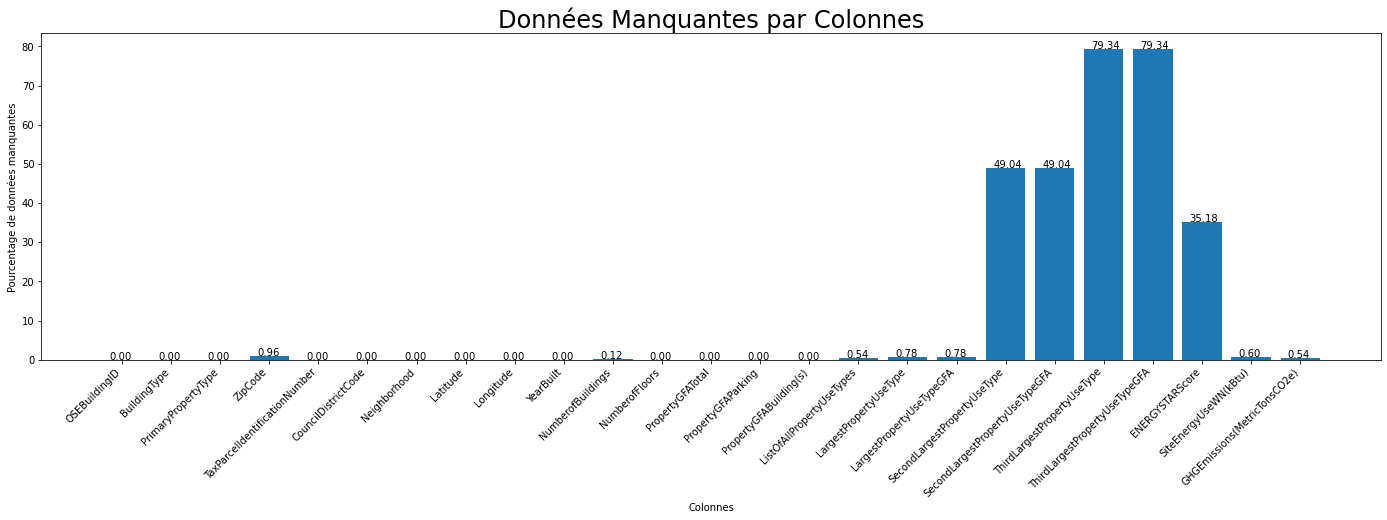

In [12]:
# Preparation pour le graphe
missing_df = data_df.isna().sum().to_frame()
missing_df = missing_df/len(data_df)*100
missing_df.columns = ['Count']

# Graphe
y = missing_df['Count']                      
fig, ax = plt.subplots(figsize = (24,6))

ax.bar(missing_df.index, y)
xlocs, xlabs = plt.xticks()
ax.set_xticklabels(missing_df.index,rotation=45, horizontalalignment= 'right')
ax.set_xlabel('Colonnes')
ax.set_ylabel('Pourcentage de données manquantes')
for i, v in enumerate(y):
    plt.text(xlocs[i] - 0.25, v + 0.06, "{:02.2f}".format(v))

plt.title("Données Manquantes par Colonnes", fontsize = 24)
plt.savefig('Results' + '/' + 'Images' + '/' + 'Données Manquantes.png',bbox_inches='tight',pad_inches = 1, dpi= 120)
plt.show()

Au vue des résultats, nous allons supprimer les deux colonnes avec presque 80% de données manquantes.

In [13]:
# On supprime les colonnes avec peu de donnees
dropColumnList = missing_df[missing_df['Count'] > 70].index.tolist()

for col in data_df.columns:
    if col in dropColumnList:
        data_df = data_df.drop(columns = col)

## Changement des unités en unités du système internationnal ##

In [14]:
# Changement en unité du système international pour le dataset 

# 1 BTU equals about 1055.06 J
jouleConverter = 1055.06 / 1e6
# 1 sf = 0.09290304 m^2
squareMeterConverter = 0.09290304

data_df['PropertyGFATotal'] = data_df['PropertyGFATotal'] * squareMeterConverter
data_df.rename(columns = {"PropertyGFATotal": "PropertyGFATotal(m2)"}, inplace=True)

data_df['PropertyGFAParking'] = data_df['PropertyGFAParking'] * squareMeterConverter
data_df.rename(columns = {"PropertyGFAParking": "PropertyGFAParking(m2)"}, inplace=True)

data_df['PropertyGFABuilding(s)'] = data_df['PropertyGFABuilding(s)'] * squareMeterConverter
data_df.rename(columns = {"PropertyGFABuilding(s)": "PropertyGFABuilding(s)(m2)"}, inplace=True)

data_df['LargestPropertyUseTypeGFA'] = data_df['LargestPropertyUseTypeGFA'] * squareMeterConverter
data_df.rename(columns = {"LargestPropertyUseTypeGFA": "LargestPropertyUseTypeGFA(m2)"}, inplace=True)

data_df['SecondLargestPropertyUseTypeGFA'] = data_df['SecondLargestPropertyUseTypeGFA'] * squareMeterConverter
data_df.rename(columns = {"SecondLargestPropertyUseTypeGFA": "SecondLargestPropertyUseTypeGFA(m2)"}, inplace=True)

data_df['SiteEnergyUseWN(kBtu)'] = data_df['SiteEnergyUseWN(kBtu)'] * jouleConverter
data_df.rename(columns = {"SiteEnergyUseWN(kBtu)": "SiteEnergyUseWN(GJ)"}, inplace=True)

## Distribution des données ##

On regarde la distribution des données pour avoir une idée des changements éventuels à effectuer.

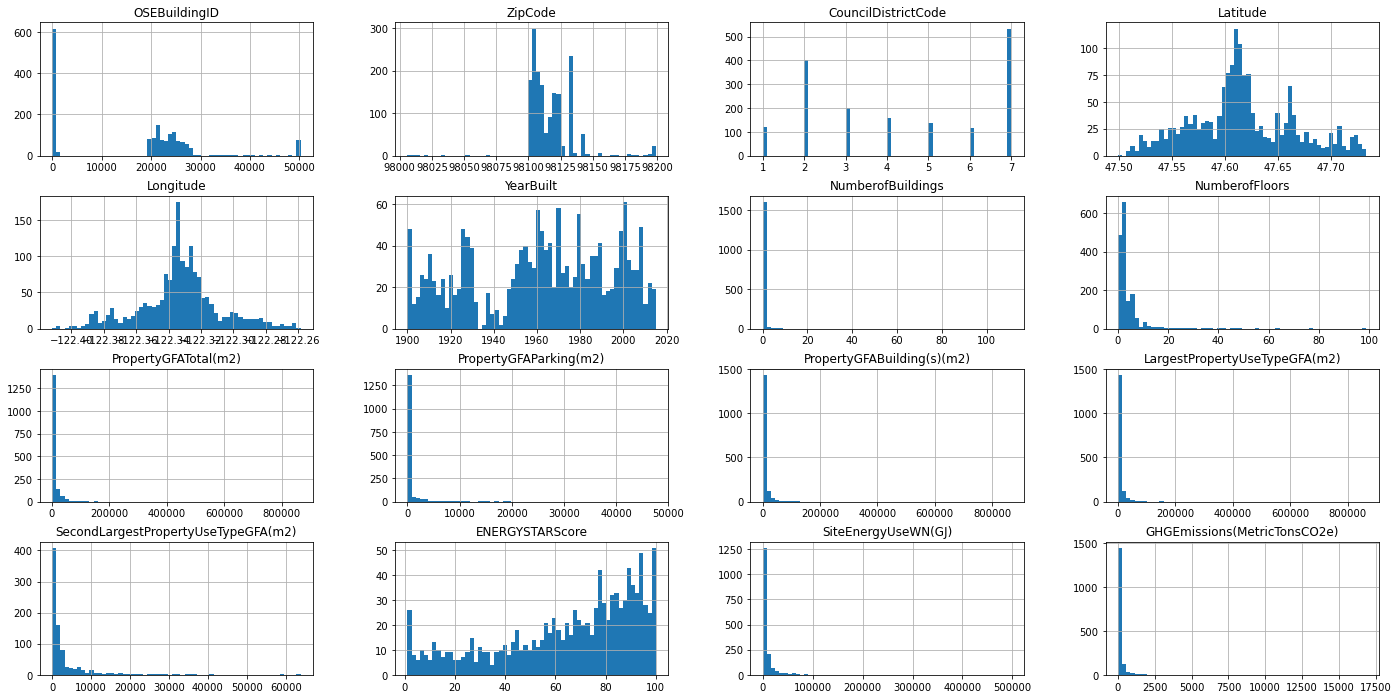

In [15]:
# Les colonnes numériques sont considérées comme des chaines de caractères donc
# nous allons les remettre en nombre.
data_df = data_df.apply(pd.to_numeric, errors = 'ignore')

# On peut maintenant regarder la distribution des données numériques
data_df.hist(figsize = (24,12), bins = 60)
plt.savefig('Results' + '/' + 'Images' + '/' + 'Distribution_1.png',bbox_inches='tight',pad_inches = 1, dpi= 120)

La latitude et la longitude ont une distribution qui semble normale. Les autres colonnes dans les huit premières affichées sont des variables catégorielles et leur distribution ne nous intéresse pas ici.

Les sept dernières variables en revanche (en exceptant la variable 'ENERGYSTARScore') ont toutes des distributions très asymétriques avec beaucoup de petites valeurs et quelques très grandes valeurs. Ce genre de distribution est généralement plus simple à utiliser après un passage au logarithme, ce que nous allons donc faire.

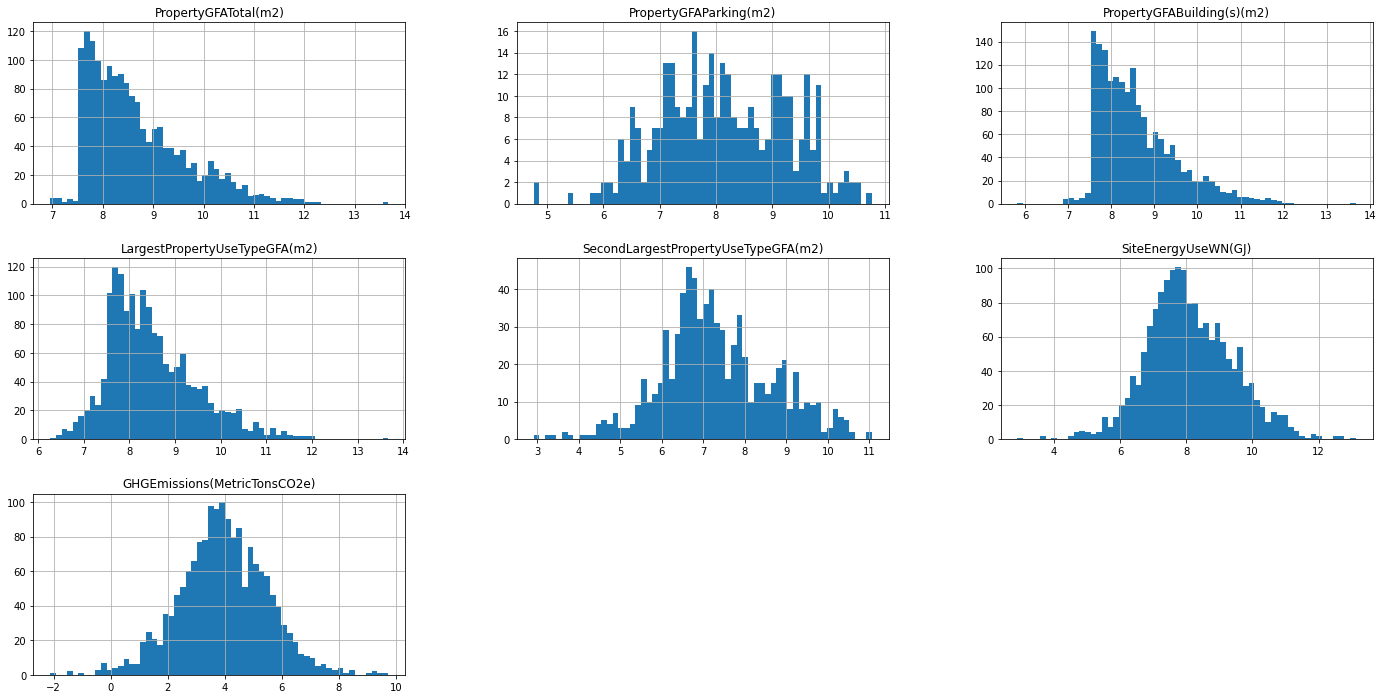

In [16]:
# Passage au log des variables identifiées
colToLog = ['PropertyGFATotal(m2)','PropertyGFAParking(m2)','PropertyGFABuilding(s)(m2)',
            'LargestPropertyUseTypeGFA(m2)','SecondLargestPropertyUseTypeGFA(m2)',
            'SiteEnergyUseWN(GJ)','GHGEmissions(MetricTonsCO2e)']
for col in colToLog:
    data_df[col].fillna(value = 1e-10, inplace = True)
    data_df[col].replace(to_replace = 0, value = 1e-10, inplace = True)
    data_df[col] = np.log(data_df[col])
    data_df[col].replace(to_replace = np.log(1e-10), value = np.nan, inplace = True)
    
# Visualisation
data_df[colToLog].hist(figsize = (24,12), bins = 60)
plt.savefig('Results' + '/' + 'Images' + '/' + 'Distribution_2.png',bbox_inches='tight',pad_inches = 1, dpi= 120)

## Suppression des cas particuliers ##

Maintenant que l'on a des distributions pseudo-normales, on va pouvoir supprimer les cas particuliers.

In [17]:
# Fonction pour identifier les cas particuliers en utilisant une déviation standard

def out_std(s, nstd=3.0, return_thresholds=False):
    data_mean, data_std = s.mean(), s.std()
    cut_off = data_std * nstd
    lower, upper = data_mean - cut_off, data_mean + cut_off
    if return_thresholds:
        return lower, upper
    else:
        return [True if x < lower or x > upper else False for x in s]

In [18]:
# Suppression des cas particuliers grâce à la fonction précédente
print('Nombre de bâtiments avant la suppression des cas particuliers : {:d}'.format(data_df.shape[0]))
outlierMaskList = []
for i in range(len(colToLog)):
    col = colToLog[i]
    outlierMask = out_std(data_df[col], nstd=3.0)
    outlierMaskList = list(data_df[col][outlierMask].index)
    data_df.drop(index = outlierMaskList, inplace = True)

data_df.reset_index(drop = True, inplace = True)
print('Nombre de bâtiments après la suppression des cas particuliers : {:d}'.format(data_df.shape[0]))

Nombre de bâtiments avant la suppression des cas particuliers : 1660
Nombre de bâtiments après la suppression des cas particuliers : 1614


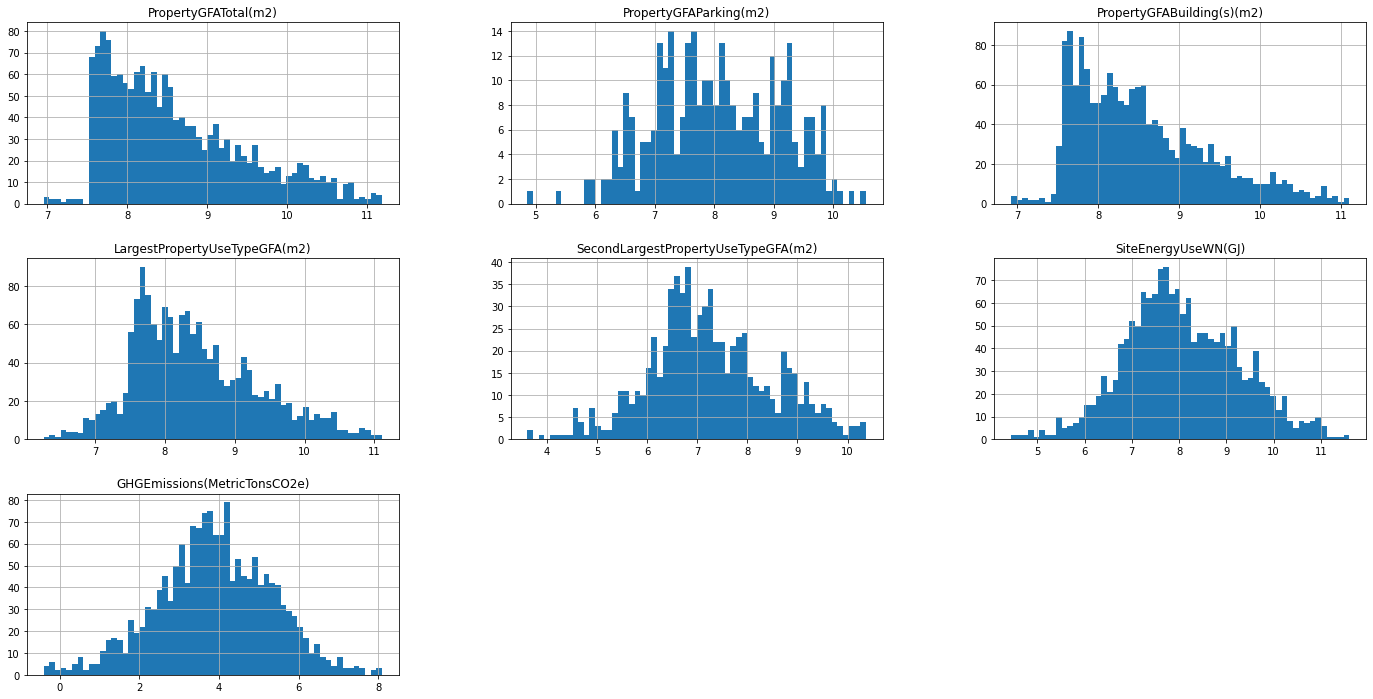

In [19]:
# Visualisation des catégories travaillées 
data_df[colToLog].hist(figsize = (24,12), bins = 60)
plt.savefig('Results' + '/' + 'Images' + '/' + 'Distribution_Outliers.png',bbox_inches='tight',pad_inches = 1, dpi= 120)

## Suppression des colonnes corrélées pour simplifier et améliorer les futures modélisations ##

Nous allons observer les corrélations entre différentes colonnes et si plusieurs colonnes sont corrélées entre elles, n'en garder qu'une. 

Cela permet d'avoir des algorithmes plus simples et donc plus rapides mais également plus robustes en général. (via une meilleure détection de relations entre variables ou une détermination des estimations de coefficient moins sensibles aux changements des données et une interprétation plus simple de manière générale)

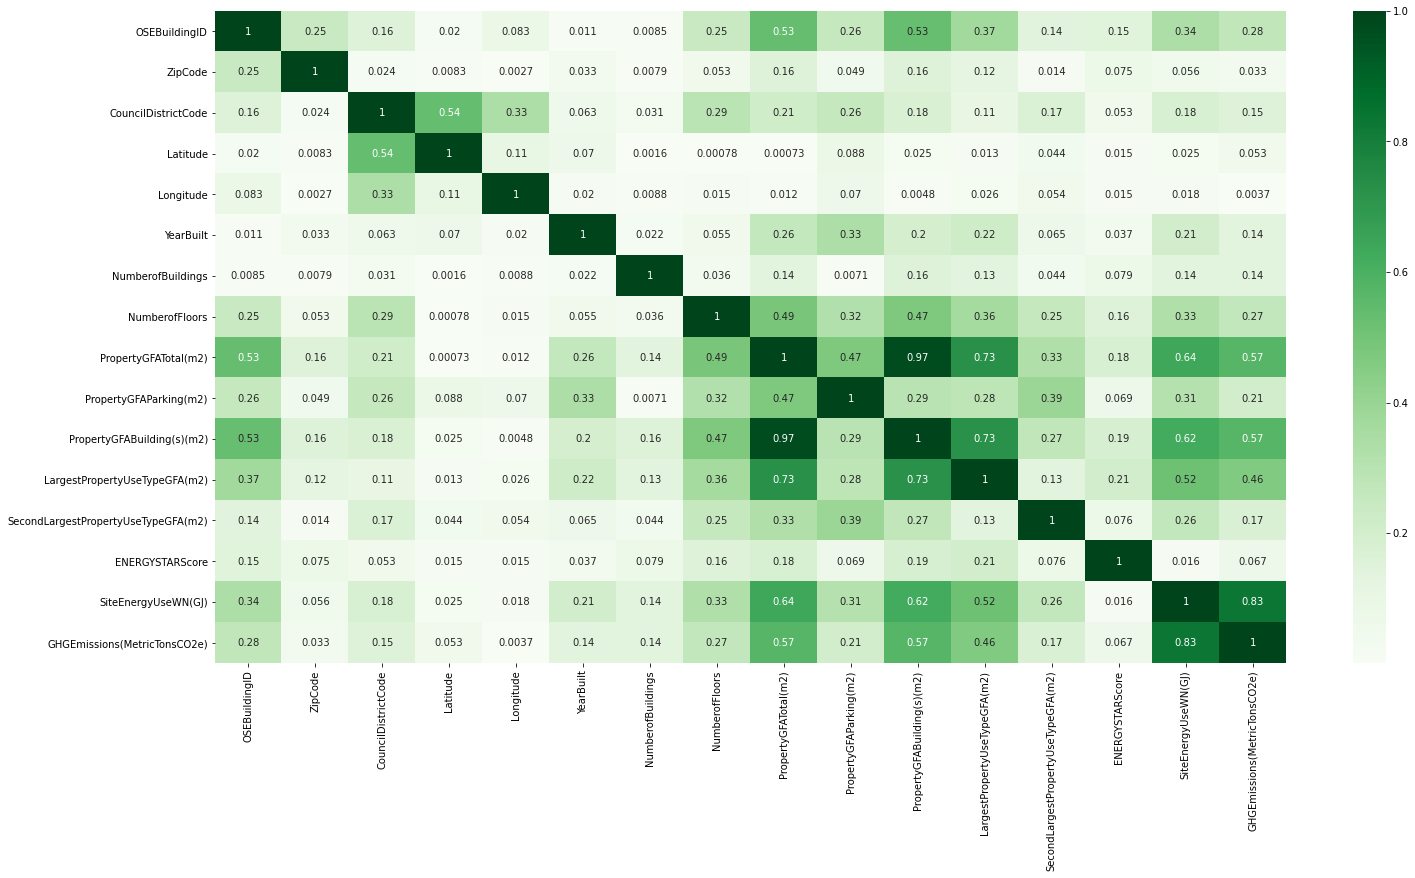

In [20]:
# On regarde la correlation des colonnes numériques donc on les sépare des colonnes catégorielles.
correlationColumns = []
for col in data_df.columns:
    if data_df[col].dtypes == 'int64':
        correlationColumns.append(col)
    elif data_df[col].dtypes == 'float64':
        correlationColumns.append(col)

# On créé un jeu de données pour avoir les indices de corrélations
correlations_df = pd.DataFrame(index = correlationColumns, columns = correlationColumns)

# On remplit le jeu de données 
cleanData_df = data_df.fillna(0)
for col1 in correlationColumns:
    for col2 in correlationColumns:
        coefCorrel = abs(st.pearsonr(cleanData_df[col1],-cleanData_df[col2])[0])
        correlations_df.loc[col1,col2] = coefCorrel
correlations_df.fillna(value = 0, inplace = True)

# On affiche le résultat
f, ax = plt.subplots(figsize=(24,12))
sns.heatmap(correlations_df, annot = True, cmap = 'Greens')
plt.savefig('Results' + '/' + 'Images' + '/' + 'Corrélations.png',bbox_inches='tight',pad_inches = 1, dpi= 120)

D'après les résultats, on peut considérer que les colonnes PropertyGFATotal(m2), PropertyGFABuilding(s)(m2) et LargestPropertyUseTypeGFA(m2) sont corrélées et on n'en gardera donc qu'une, la première car c'est la plus corrélées aux indicateurs que l'on cherche.

In [21]:
data_df.drop(columns = ['PropertyGFABuilding(s)(m2)', 'LargestPropertyUseTypeGFA(m2)'], inplace = True)

## Suppression des colonnes jugées inutiles ##

On va également supprimer quelques colonnes qui n'auront sans doute pas d'impact sur la modélisation ou qui sont redondantes afin de simplifier les modèles dans une optique de meilleure interprétabilité mais aussi de gain de temps des algorithmes de Machine Learning. 

In [22]:
data_df.drop(columns = ['TaxParcelIdentificationNumber', 'CouncilDistrictCode', 
                        'Neighborhood', 'Latitude', 'Longitude', 'ListOfAllPropertyUseTypes'], inplace = True)

## Séparation définitive du jeu de données ##

Séparation du jeu de données en un jeu contenant les bâtiments avec variables connues et un jeu avec les bâtiments dont l'énergie consommée et l'émission de GES est à prédire.

In [23]:
knownData_df = pd.DataFrame()
unknownData_df = pd.DataFrame()

for i in range(len(data_df)):
    row = data_df.iloc[i,:]
    if pd.isna(data_df.iloc[i,-1]) or pd.isna(data_df.iloc[i,-2]):
        unknownData_df = unknownData_df.append(row)
    else:
        knownData_df = knownData_df.append(row)

# Enregistrements des différents jeux de données ##

On enregistre les différents jeux de données pour pouvoir les utiliser dans le notebook de modélisation.

In [24]:
# Enregistrement du dataset pour les modélisations

data_df.to_csv('Results'+'/'+'01_AutoAllYearData.csv', index = False)
knownData_df.to_csv('Results'+'/'+'02_KnownIndicatorData.csv', index = False)
unknownData_df.to_csv('Results'+'/'+'03_UnknownIndicatorData.csv', index = False)